# 3_countrymaps_layouting

### Summary
This notebook allows for real time layouting of the annotated country parts. All changes are saved upon changing the parameters.

In [66]:
# Hidden depedency of geopandas: descartes
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import ipywidgets as widgets
from IPython.display import clear_output, display

### Figure size

In [67]:
plt.rcParams['figure.figsize'] = [20, 10]

# V) Real time layouting

In [73]:
skip_single_geometry_countries = True

In [74]:
import pickle
country_list_layout = pickle.load(open('country_list_layout.p', 'rb'))

In [75]:
# global variables
index = 0
ui = None
rows = None
cols = None
parts_btns = None
fig = None
nav_hbox = None

# Navigation functions
def next_clicked(button):
    global index
    global country_list_layout
    while True:
        index += 1
        if index == len(country_list_layout):
            index = 0
        if country_list_layout[index]['nr_parts'] > 1 or not skip_single_geometry_countries:
            break
    clear_output(wait=True)
    setup_ui(index)
    draw_country(index)
    
def previous_clicked(button):
    global index
    global country_list_layout
    while True:
        index -= 1
        if index < 0:
            index = len(country_list_layout) - 1
        if country_list_layout[index]['nr_parts'] > 1 or not skip_single_geometry_countries:
            break
    clear_output(wait=True)
    setup_ui(index)
    draw_country(index)

# Navigation buttons
goto_next = widgets.Button(
    description='Next country',
    disabled=False,
    button_style='',
    tooltip='Next country',
    icon=''
)
goto_previous = widgets.Button(
    description='Previous country',
    disabled=False,
    button_style='',
    tooltip='Previous country',
    icon=''
)

# Naviation eventlisteners
goto_next.on_click(next_clicked)
goto_previous.on_click(previous_clicked)

# Navigation layout
nav_hbox = widgets.HBox([goto_previous, goto_next])

In [76]:
# This function creates all input elements for the country at the index. Navigation buttons are reused.
def setup_ui(index):
    global country_list_layout
    global ui
    global nav_hbox
    global rows
    global cols
    global parts_btns
    
    # Create UI elements
    # Total rows and cols inputs
    rows = widgets.IntText(
        value=country_list_layout[index]['rows'],
        description='Rows',
        layout=widgets.Layout(width='15%')
    )
    cols = widgets.IntText(
        value=country_list_layout[index]['cols'],
        description='Cols',
        layout=widgets.Layout(width='15%')
    )
    # For each country part, create rowroot, colroot, rowspan and colspan.
    parts_btns = []
    for p in country_list_layout[index]['parts']:
        parts_btns.append({
            'name': widgets.Label(
                value=p['name'],
                layout=widgets.Layout(width='15%')
            ),
            'rowroot':widgets.IntText(
                value=p['rowroot'],
                description='RRoot',
                layout=widgets.Layout(width='15%')
            ),
            'colroot':widgets.IntText(
                value=p['colroot'],
                description='CRoot',
                layout=widgets.Layout(width='15%')
            ),
            'rowspan':widgets.IntText(
                value=p['rowspan'],
                description='RSpan',
                layout=widgets.Layout(width='15%')
            ),
            'colspan':widgets.IntText(
                value=p['colspan'],
                description='CSpan',
                layout=widgets.Layout(width='15%')
            ),
        })
    # Assign UI eventlistener to all inputs
    for b in [rows, cols] + [btn for part_btns in parts_btns for btn in part_btns.values()]:
        b.observe(on_value_change, names='value')
    # Layout UI elements
    rows_cols_hbox = widgets.HBox([rows, cols])
    parts_btns_hboxes = []
    for p in parts_btns:
        parts_btns_hboxes.append(widgets.HBox(tuple(b for b in p.values())))
    ui = widgets.VBox(tuple([nav_hbox, rows_cols_hbox, *parts_btns_hboxes]))
    # Display UI
    display(ui)

# This function draws the country at the index using the parameters from the country list.
def draw_country(index):
    global country_list_layout
    rows = country_list_layout[index]['rows']
    cols = country_list_layout[index]['cols']
    for p in country_list_layout[index]['parts']:
        ax = plt.subplot2grid(
            shape=(rows, cols), 
            loc=(p['rowroot'], p['colroot']),
            colspan=p['colspan'],
            rowspan=p['rowspan']
        )
        p['geometry'].plot(ax=ax, facecolor='lightgray', edgecolor='gray')
        plt.axis('equal')
        ax.set_title(p['name'])
        ax.set_axis_off()
    plt.show();

# This function gets called each time a UI element is clicked (except for nav buttons).
# Updates and pickles list, sets up UI, draws country.
def on_value_change(change):
    global country_list_layout
    global index
    global rows
    global cols
    global parts_btns
    clear_output(wait=True)
    country_list_layout[index]['rows'] = rows.value
    country_list_layout[index]['cols'] = cols.value
    for i, part in enumerate(country_list_layout[index]['parts']):
        country_list_layout[index]['parts'][i]['rowroot'] = parts_btns[i]['rowroot'].value
        country_list_layout[index]['parts'][i]['colroot'] = parts_btns[i]['colroot'].value
        country_list_layout[index]['parts'][i]['rowspan'] = parts_btns[i]['rowspan'].value
        country_list_layout[index]['parts'][i]['colspan'] = parts_btns[i]['colspan'].value
    setup_ui(index)
    try:
        draw_country(index)
        pickle.dump(country_list_layout, open('country_list_layout.p', 'wb'))
    except:
        pass

### Entry point

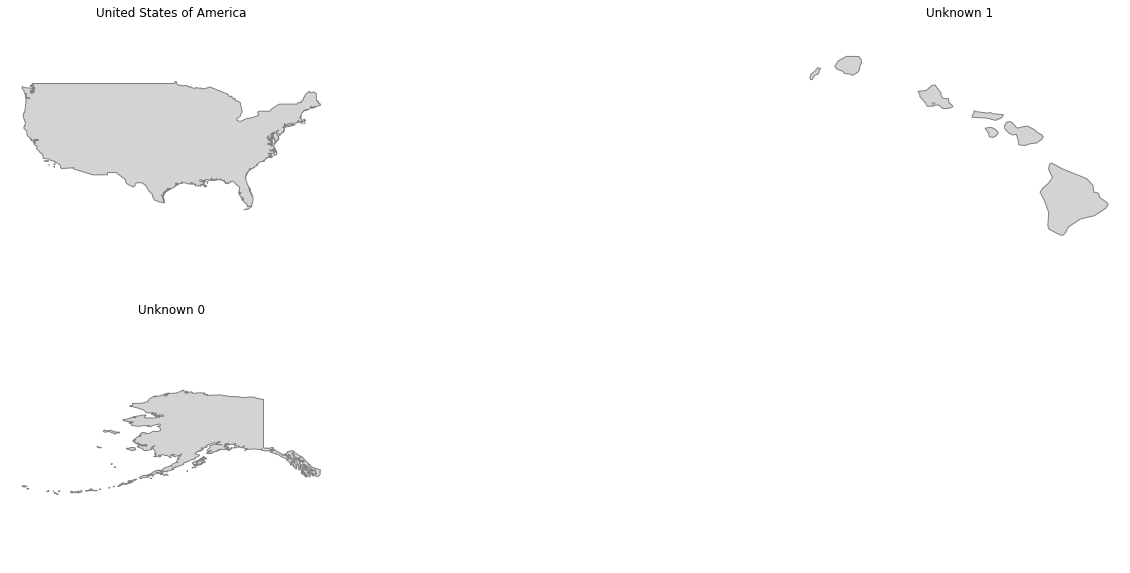

In [77]:
next_clicked(None)